# Assignment 1

**Student Name: Panteleimon Manouselis**

**Reg No: 3084493**

**Group No: 11**

In [3]:
# Load all the needed packages for this assignment
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import pandas as pd
import pingouin as pg
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

## Exercise 1.1 - Load data

a) Load the CIFAR10 dataset.

In [4]:
# load CIFAR10 dataset using torchvision
dataset = torchvision.datasets.CIFAR10(root='./data')

b) Print the number of samples and the number of classes present in the dataset.

In [5]:
# Print the number of samples and the number of classes present in the dataset.
print("Number of samples of CIFAR10 dataset: ", len(dataset))
print("Number of classes of CIFAR10 dataset: ", len(dataset.classes))

Number of samples of CIFAR10 dataset:  50000
Number of classes of CIFAR10 dataset:  10


c) Print the shape of an image in the dataset.

In [6]:
# print the shape of an image in the dataset
images = np.array(dataset.data) # (50000, 32, 32, 3)
print("Shape of an image in CIFAR10 dataset: ", images[0].shape)

Shape of an image in CIFAR10 dataset:  (32, 32, 3)


## Exercise 1.2 - Quantify dataset

a) Print the number of samples per category.

In [7]:
# Create a dictionary to map the category index to its name
category_names = dataset.class_to_idx
# invert key and value of the dictionary
category_names = {v: k for k, v in category_names.items()}
print("Each index and the corresponding category: ", category_names)
# Get a list categorizing each image in the dataset
category_of_each_image = np.array(dataset.targets) # list of 50000 integers
# Calculate the number of samples per category.
sample_per_categoryidx = np.bincount(category_of_each_image)
# Print the number of samples per category.
print("Number of samples per category: ", sample_per_categoryidx)

Each index and the corresponding category:  {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
Number of samples per category:  [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]


b) Plot the number of samples per category using a bar plot.

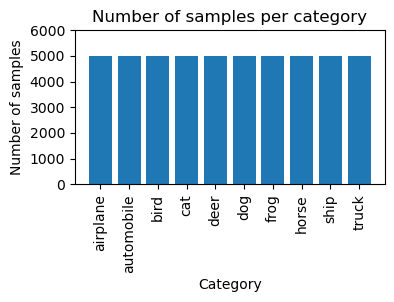

In [8]:
# Plot the number of samples per category using a bar plot.
fig = plt.figure(figsize=(4, 2))
plt.bar(dataset.classes, sample_per_categoryidx)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 7000, 1000))
# Add axis labels and title.
plt.xlabel("Category")
plt.ylabel("Number of samples")
plt.title("Number of samples per category")
plt.show()

**Reflection**: Answer the below question

Are you working with a balanced or an unbalanced dataset? Are there majoritarian classes? Do you think this will affect the later analysis and training of your models?

**Answer:**

As seen in the previous plot, there are 5000 samples for each class so, it is a balanced dataset. There are no majoritarian classes as each class has the same number of samples.

In general, working with an unbalanced dataset can affect the later analysis and training of models as it can introduce bias towards the majority class(es). This is not the case for this dataset.

## Exercise 1.3 - Visualize images in your dataset

Create a figure with n x 4 sub-plots. The value of 'n' depends on the number of categories present in the dataset. As the title of each row in your figure, indicate the category it belongs to.

In [9]:
# Create a list to store images for each category
category_images = [[] for _ in range(10)]

# Split the dataset images into 10 lists, one for each category.
for (image, category) in dataset:
    category_images[category].append(image)

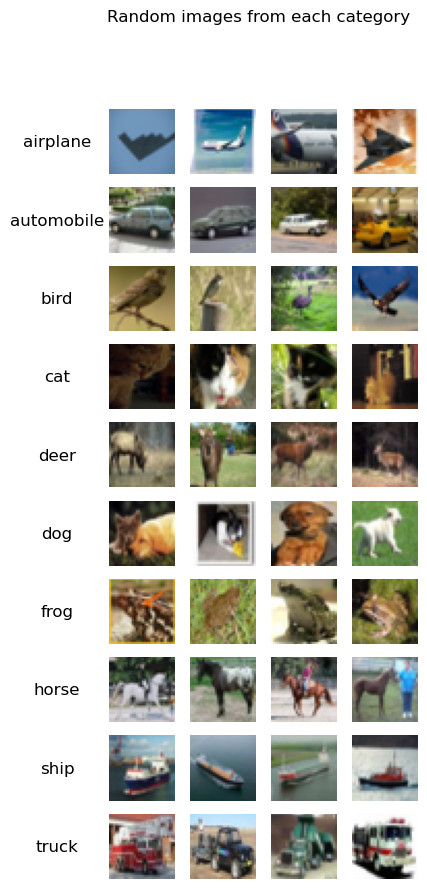

In [10]:
# Create a 10x4 grid of subplots
fig, axes = plt.subplots(10, 4, figsize=(4, 10))
fig.suptitle("Random images from each category")

# Iterate over each category
for i, images in enumerate(category_images):
    # Set the title of the first subplot in the row to the category name
    axes[i, 0].set_title(category_names[i], x=-0.8, y=0.3)
    # Iterate over each of the four subplots in the row
    for j in range(4):
        # Select a random image from the category's list of images
        image = images[np.random.randint(0, len(images))]
        # Show the image in the subplot and turn off axis labels
        axes[i, j].imshow(image)
        axes[i, j].set_axis_off()

# Show the plot
plt.show()

## Exercise 1.4 - RGB feature extraction

**Question:** 

Extract RGB values from each image in your dataset as three seperate lists(one per channel). Each list should have 8 values. To do so, you can compute the histogram of each channel with 8 bins. Then you have to concatenate the values of all the three channels together resulting in a feature vector of size 24. This feature vector is the descriptor of an image in your dataset. You will have to do this for all the images present in your dataset in order to get the overall RGB descriptor which will be of size (n,24). Here 'n' depends on the number of samples present in the dataset.

**Answer:**

In [11]:
# Define the number of bins for each channel histogram
num_bins = 8

# Initialize empty arrays to hold the RGB descriptor for all images
rgb_descriptor = np.zeros((len(dataset), num_bins * 3))

# Loop through each image in the dataset and compute the RGB descriptor
for i, (image, label) in enumerate(dataset):
    # Convert the PIL image to a NumPy array
    image_np = np.array(image, dtype=np.uint8)
    # Compute the histogram for each channel with num_bins bins
    hist_red, _ = np.histogram(image_np[:,:,0], bins=num_bins, range=(0,255))
    hist_green, _ = np.histogram(image_np[:,:,1], bins=num_bins, range=(0,255))
    hist_blue, _ = np.histogram(image_np[:,:,2], bins=num_bins, range=(0,255))
    # Concatenate the histogram values for each channel into a single feature vector
    rgb_descriptor[i] = np.concatenate([hist_red, hist_green, hist_blue])

Here, `rgb_descriptor` is a NumPy array of shape `(n, 24)`, where `n` is the number of samples in the dataset. Each row of `rgb_descriptor` corresponds to the RGB descriptor of a single image in the dataset. The first 8 values correspond to the histogram of the red channel, the next 8 values correspond to the histogram of the green channel, and the last 8 values correspond to the histogram of the blue channel.

## Exercise 1.5 - Correlation among samples of the different categories

After extracting the overall RGB descriptor from previous exercise, concatenate the labels(each category represents a label) to it.

In [13]:
# Concatinacting the labels to the RGB descriptor
descriptor = np.concatenate([rgb_descriptor, category_of_each_image.reshape(-1, 1)], axis=1)

**a) Compute the intra-class variability of your dataset.**

Intra-class correlation aims at understanding the compactness of a class/group/category. This is done basically through the computation of a score of similarity among samples. In this assignment, the purpose of doing intra-class correlation is basically to check the similarity between the samples of each class, so that we would have an idea of how similar the dataset is, for each class.

For this, you can use the implementation from the pingouin package- https://pingouin-stats.org/build/html/generated/pingouin.intraclass_corr.html

Here is an example: https://www.statology.org/intraclass-correlation-coefficient-python/. You are not obliged to follow it. You can implement your own function or another one you may implement.

In [14]:
# The target is the feature
targets = [[i for i in range(24)]*5000 for _ in range(10)]
# Our different judges are the 5000 images
raters = [[i for i in range(5000) for _ in range(24)] for _ in range(10)]
# The rating is the value of the 24 RGB features 
ratings = [[] for _ in range(10)]
for i, descriptor_i in enumerate(descriptor):
    # Get the RGB descriptor and the label for the current sample
    rgb_desc = descriptor_i[0:24].copy()
    target_idx = int(descriptor_i[24].copy())
    ratings[target_idx] = ratings[target_idx] + rgb_desc.tolist()

In [15]:
# Create a list to store the dataframes for each category
df_list = []
# Create dataframe of each category and store it in the list
for i in range(10):
    df_list.append(pd.DataFrame(
        data={'features': targets[i], 'images': raters[i], 'features_value': ratings[i]}))
# View 40 rows of the dataframe for the first category
df_list[0].iloc[4960:5000]

,features,images,features_value
4960,16,206,18.0
4961,17,206,148.0
4962,18,206,123.0
4963,19,206,60.0
4964,20,206,59.0
4965,21,206,265.0
4966,22,206,193.0
4967,23,206,158.0
4968,0,207,0.0
4969,1,207,0.0


In [16]:
# Create a list to store the ICC values for each category
icc_list = []
# Calculate the ICC for each category
for i in range(10):
    icc = pg.intraclass_corr(data=df_list[i], targets='features', raters='images', ratings='features_value')
    icc_list.append(icc)

In [17]:
icc_list[1].set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.105099,588.210536,23,119976,0.0,"[0.07, 0.19]"
ICC2,Single random raters,0.105092,563.701764,23,114977,0.0,"[0.07, 0.19]"
ICC3,Single fixed raters,0.101156,563.701764,23,114977,0.0,"[0.06, 0.18]"
ICC1k,Average raters absolute,0.998300,588.210536,23,119976,0.0,"[1.0, 1.0]"
ICC2k,Average random raters,0.998300,563.701764,23,114977,0.0,"[1.0, 1.0]"
ICC3k,Average fixed raters,0.998226,563.701764,23,114977,0.0,"[1.0, 1.0]"


**b) Compute the inter-class variability of your dataset.**

Inter-class correlation aims at understanding the relationship/correlation among the classes/categories present in your dataset. For this, you could compute a measure (for example mean, std etc.) collectively for all the samples belonging to each and every class of the dataset. Then you could make use of this measure to find the correlation among the classes/categories using the standard pandas dataframe correlation function. Link: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html

**Answer:**

Firstly, I create a pandas dataframe with the RGB descriptors and labels:

In [18]:
# create a pandas dataframe df with the RGB descriptors as columns and the corresponding labels for each image as a separate column.
rgb_des_df = pd.DataFrame(descriptor, columns=[f'r{i}' for i in range(8)] +
                                         [f'g{i}' for i in range(8)] +
                                         [f'b{i}' for i in range(8)] + ['label'])

I will use the mean and standard deviation as the measures upon which I will compute the correlation among the classes/categories. The mean and standard deviation are computed for each class separately using pandas `groupby()` to group the images belonging to the same label as one group.

In [19]:
# group images by their label
grouped_dataframes = rgb_des_df.groupby('label')
# For each group, calculate the mean of each column (i.e. the mean of each RGB descriptor). But first drop the label column.
mean_df = grouped_dataframes.apply(lambda group_df: group_df.drop('label', axis=1).mean(axis=0))
# For each group, calculate the standard deviation of each column (i.e. the std dev of each RGB descriptor). But first drop the label column.
std_df = grouped_dataframes.apply(lambda group_df: group_df.drop('label', axis=1).std(axis=0))
# transpose the mean and standard deviation dataframes so that the rows are the RGB descriptors and the columns are the categories
# this is because the corr function correlates between columns, so we need each column to describe a different category
mean_df = mean_df.T
std_df = std_df.T
# calculate the correlation between each class
correlation_matrix_mean = mean_df.corr()
correlation_matrix_std = std_df.corr()

**c) Compute the Silhouette score.**

The Silhouette score is used to assess the performance of using unsupervised machine learning (clustering). We can also use it here to assess the compactness of the extracted descriptors per category and for the group of categories as their mean.

You can use the function available in Sklearn - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

**Answer:**

In [20]:
# Silhouette score can not be computed for less than 2 clusters. Therefore, we can not compute the silhouette score for one category.
# Instead, we will compute the silhouette score for the group of categories as their mean.
rgb_descriptor_np = np.array(rgb_descriptor, dtype=np.int8)

# Assign the labels array to a variable
labels_np = np.array(category_of_each_image, dtype=np.int8)

# Call the silhouette_score function with the RGB descriptor array and the labels array
silhouette = silhouette_score(rgb_descriptor_np, labels_np)

# Print the result
print("Silhouette score:", silhouette)

Silhouette score: -0.04832272638159245


Reflection: (Answer the below questions)

**1. Does Intra-class correlation score/coefficient help you assess the degree of similarity among the samples of a category?**

Yes, it does. The higher the intra-class correlation score, the more similar the samples of a category are. There are different types of ICCs types computed by the `intraclass_corr()` function: ICC1, ICC2, ICC3, ICC1k, ICC2k and ICC3k. I will focus on ICC3k which takes into consideration all the raters (which are the images in our case) of the category and compute the average of them. According to Koo & Li (https://pubmed.ncbi.nlm.nih.gov/27330520/), an ICC score less than 0.5 indicates poor reliability, between 0.5 and 0.75 indicates moderate reliability, and greater than 0.75 indicates excellent reliability. 

I can extract the ICC3k score for each category from the icclist dataframe as follows:

In [21]:
# extract the icc3k values from the icc_list
icc3k = [icc_list[i].iloc[5, 2] for i in range(10)]
print(icc3k)

[0.9973889670149843, 0.9982260122914172, 0.998782117751788, 0.9984062577070119, 0.9994656801597471, 0.9987583466101729, 0.9994519384442667, 0.9991071795714372, 0.9983709422295831, 0.99808147713443]


As seen, the ICC3k scores are all above 0.75, which indicates that each category has a high degree of similarity.

**2. What can you deduce from the Inter-class correlation and Silhouette score?**

**(A) Inter-class correlation:**

For the inter-class correlation, I computed the mean and standard deviation for each category separately. I then compute the correlation between the mean and standard deviation of each category. The correlation is computed using the `corr()` function of pandas dataframe. The correlation matrices are as follows:

In [22]:
print("Correlation between categories using mean:")
print(correlation_matrix_mean)

Correlation between categories using mean:
label       0.0       1.0       2.0       3.0       4.0       5.0       6.0  \
label                                                                         
0.0    1.000000  0.052321  0.470928  0.139518  0.322096  0.249280  0.123002   
1.0    0.052321  1.000000  0.806705  0.916883  0.881101  0.863930  0.931807   
2.0    0.470928  0.806705  1.000000  0.916491  0.979866  0.948224  0.907693   
3.0    0.139518  0.916883  0.916491  1.000000  0.954946  0.984555  0.981524   
4.0    0.322096  0.881101  0.979866  0.954946  1.000000  0.962833  0.959474   
5.0    0.249280  0.863930  0.948224  0.984555  0.962833  1.000000  0.952901   
6.0    0.123002  0.931807  0.907693  0.981524  0.959474  0.952901  1.000000   
7.0    0.315648  0.866904  0.968539  0.962153  0.984896  0.968334  0.956356   
8.0    0.887582  0.355914  0.674754  0.417146  0.564242  0.525305  0.374512   
9.0    0.337923  0.890496  0.835521  0.837122  0.876925  0.806994  0.859290   

label   

In [23]:
print("Correlation between categories using standard deviation:")
print(correlation_matrix_std)

Correlation between categories using standard deviation:
label       0.0       1.0       2.0       3.0       4.0       5.0       6.0  \
label                                                                         
0.0    1.000000  0.090201  0.299888 -0.376099 -0.353592 -0.604427 -0.559948   
1.0    0.090201  1.000000 -0.234428  0.831213 -0.223259  0.457881  0.435331   
2.0    0.299888 -0.234428  1.000000 -0.134598  0.749078  0.153255  0.250879   
3.0   -0.376099  0.831213 -0.134598  1.000000  0.144707  0.830755  0.790263   
4.0   -0.353592 -0.223259  0.749078  0.144707  1.000000  0.560601  0.668649   
5.0   -0.604427  0.457881  0.153255  0.830755  0.560601  1.000000  0.930672   
6.0   -0.559948  0.435331  0.250879  0.790263  0.668649  0.930672  1.000000   
7.0   -0.310055  0.596848  0.345869  0.821434  0.560472  0.849665  0.844771   
8.0    0.934342  0.046061  0.137067 -0.445017 -0.444436 -0.719225 -0.635524   
9.0    0.413783  0.904913 -0.117969  0.597604 -0.313728  0.194293  0.18243

Of course, both matrices are symmetric because correlation between category 1 and category 2 is the same as correlation between category 2 and category 1. The correlation based on the mean and standard deviation of the same category is 1.0. The correlation based on the mean and standard deviation of different categories is between -1.0 and 1.0. The closer the correlation is to 1.0, the more similar the mean and standard deviation of the categories are. The closer the correlation is to -1.0, the more different the mean and standard deviation of the categories are.

It is seen that the correlation between certain categories is high and between other certain categorie is low. If we take the mean criteria for example, we will see that the correlation between deers (categories 4) and dogs (category 5) is 0.962833 while that between airplanes (category 0) and cats (category 3) is 0.139518. This means that the mean of the RGB descriptors of the deers and dogs are very similar while the mean of the RGB descriptors of the airplanes and frogs are very different. This indicates that for a classifier, it will be easier to distinguish between the airplanes and cats than between the deers and dogs.

**(B) Silhouette score:**

The calculated Silhouette Score is -0.04832272638159245. This means that the compactness of the extracted descriptors per category and for the group of categories as their mean is not good. This is because the Silhouette Score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The closer the score is to 1.0, the better the compactness. The closer the score is to -1.0, the worse the compactness. A score near 0.0 indicates overlapping clusters which is our case here.

## Exercise 1.6 - Dimensionality reduction for visualization

We can visualize large datasets having higher dimensions or features in 2- or 3-dimensional spaces. For this, you need to reduce the dimensionality of the data.

In this exercise, you are asked to use PCA for reducing dimensionality.

Link to function to apply PCA: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Create the following two figures:

**a) Rely on the first 2 principal components to plot the samples of your dataset. Use one color per class.**

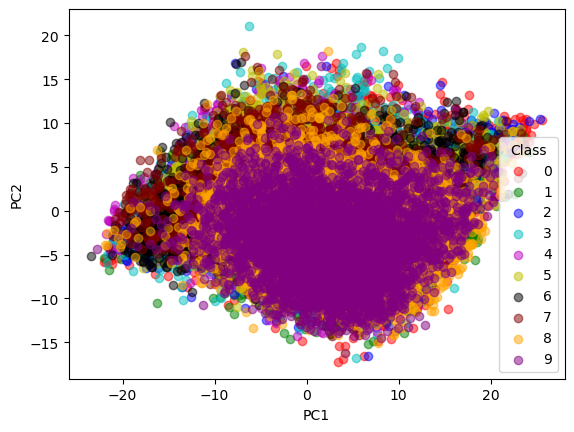

In [24]:
images = dataset.data
labels = category_of_each_image

# Flatten the images so that they stored in a 2D array of shape (num_images, num_pixels). This is needed before applying PCA
# to the data because PCA operates on 2-dimensional arrays where each row represents a sample and each column represents a feature.
data = images.reshape(images.shape[0], -1)

# normalize pixel values to [0,1]
data = data / 255.

# Perform PCA to reduce dimensionality to 2
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# Plot samples using the first 2 principal components
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'maroon', 'orange', 'purple']

for i in range(10):
    plt.scatter(data_pca[labels==i, 0], data_pca[labels==i, 1], c=colors[i], label=i, alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Class')
plt.show()

**b) Rely on the first 3 principal components to create a 3D plot. Use one color per class.**

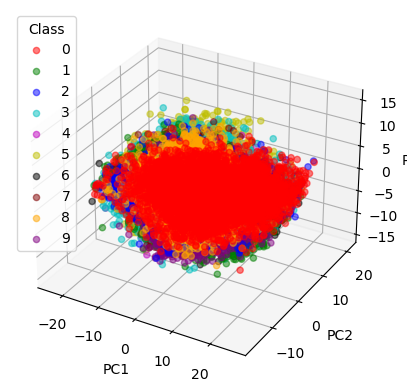

In [26]:
# Perform PCA to reduce dimensionality to 3
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data)

# Plot samples using the first 3 principal components
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'maroon', 'orange', 'purple']

for i in range(10):
    ax.scatter(data_pca[labels==i, 0], data_pca[labels==i, 1], data_pca[labels==i, 2], c=colors[i], label=i, alpha=0.5)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(title='Class')
plt.show()


## Exercise 1.7 - Reflection

**a) Will you obtain the same visualisation in the feature space for different extracted features?**

No, different extracted features will generally result in different visualizations in the feature space. This is because each feature extraction technique captures different aspects of the data, and may emphasize different patterns or structures in the data.

For example, when we applied PCA to the dataset, the first few principal components captured the largest sources of variation in the data. If we extract different features using a different technique, such as a convolutional neural network, the resulting features may capture different aspects of the data that are not captured by PCA.

**b) Are the classes distinguishable on the feature space when relying on PCA over RGB?**

No, relying on PCA over RGB does not easly distinguish between different classes in the feature space. As seen in the previous two graphs, it is difficult to draw borders that seperates classes from each other. 

**c) What other visualization could you include to better describe your data?**

Because PCA is a linear technique, it does not capture non-linear relationships between the features. This is why using non-linear techniques such as t-SNE to visualize the data in the feature space might be more suitable.

Another technique to use are the Autoencoders which are neural networks that are trained to reconstruct the input data from a lower-dimensional representation. By visualizing the lower-dimensional representation, we can get insights into the underlying structure of the data.